# Configuration

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import altair as alt 
from scipy.stats import hypergeom, mannwhitneyu
from ipywidgets import interactive

# Data Processing

In [74]:
df = pd.read_csv('../data/KP_experiment_results_df.csv')

df['Language_code'] = df.apply(lambda x: x['Language'][:2], axis=1)    

In [75]:
grouped = df.groupby('Medium')
pictures = grouped.get_group('Pictures')
annotated = grouped.get_group("Annotated Pictures")
words = grouped.get_group("Words")

# Exploratory data analysis 

## Data exploration

In [76]:
df.head()

,Medium,Items,Language,Language_code
0,Pictures,13,C1 (Advanced English),C1
1,Pictures,15,C1 (Advanced English),C1
2,Pictures,7,B2 (Upper-Intermediate English),B2
3,Pictures,13,B2 (Upper-Intermediate English),B2
4,Pictures,9,C1 (Advanced English),C1


In [77]:
statistics_all = df.describe()
statistics_grouped = df.groupby('Medium').describe()['Items']
statistics_all
with open('../results/statistics_all.html', 'w') as file:
    html_all = statistics_all.to_html()
    file.write(html_all)

with open('../results/statistics_grouped.html', 'w') as file:
    html_grouped = statistics_grouped.to_html()
    file.write(html_grouped)


## Visualisations

In [78]:
plt.xkcd()
plt.rcdefaults()
plt.rcParams['figure.titlesize'] = 'xx-large'

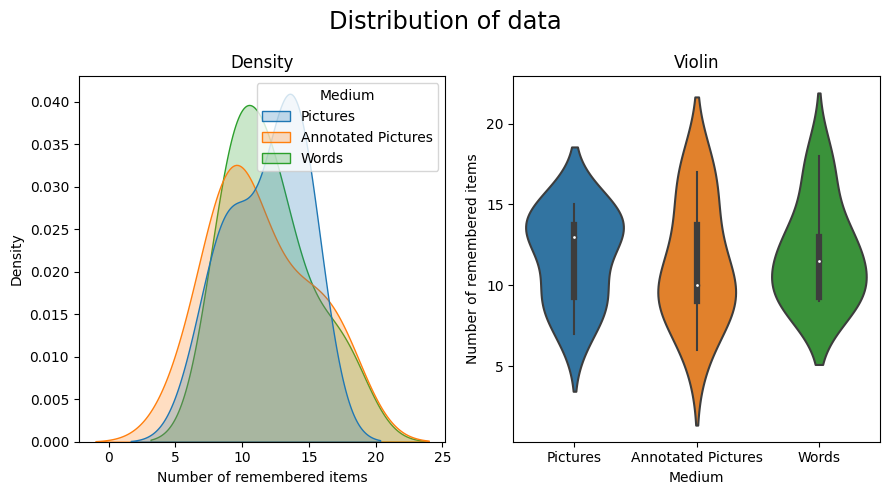

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

density = sns.kdeplot(data=df, x="Items", hue="Medium", legend=True, fill=True, ax=ax[0])
violin = sns.violinplot(data=df, x='Medium', y='Items', ax=ax[1])

ax[0].set(title="Density", xlabel="Number of remembered items")
ax[1].set(title='Violin', ylabel="Number of remembered items")

fig.suptitle("Distribution of data")
fig.tight_layout()

plt.savefig('../figures/Violin_density.png')

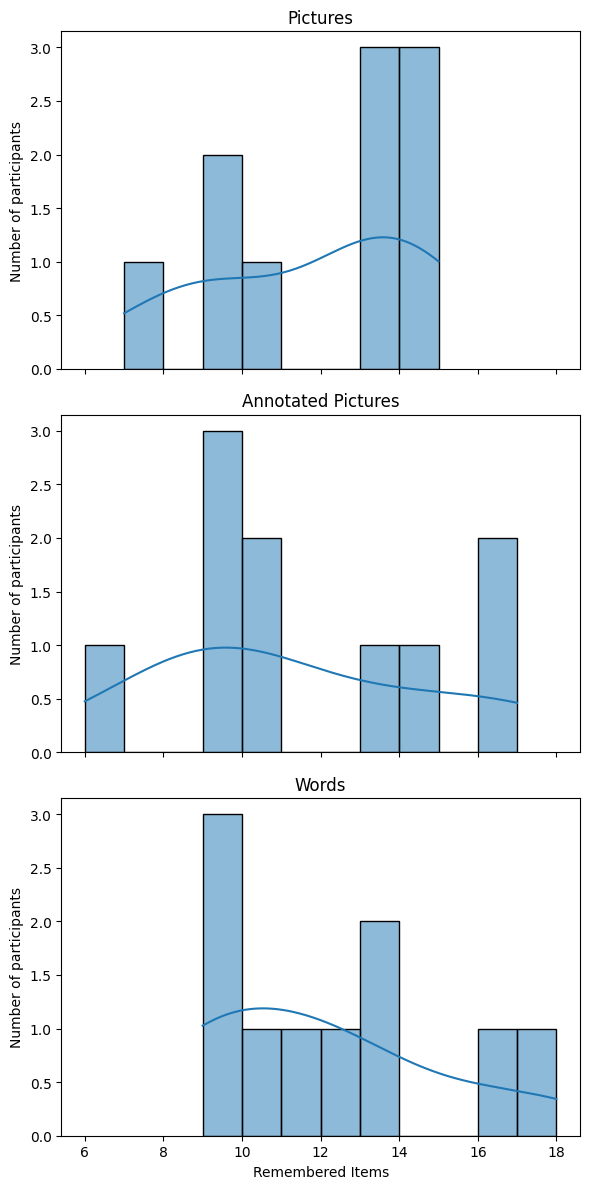

In [80]:
fig, axes = plt.subplots(nrows=3, figsize=(6, 12), sharex=True)

configs = {'x': "Items", 'kde': True, 'binwidth': 1}

sns.histplot(pictures, ax=axes[0], **configs)
sns.histplot(annotated, ax=axes[1], **configs)
sns.histplot(words, ax=axes[2], **configs)

axes[0].set(title='Pictures', ylabel='Number of participants')
axes[1].set(title='Annotated Pictures', ylabel='Number of participants')
axes[2].set(title='Words', ylabel='Number of participants', xlabel='Remembered Items')

fig.tight_layout()

plt.savefig('../figures/Distribution_bar_plot.png')

# Significance testing

**Different test procedures**
1. Test for shift in different groups of the observed location via Wilcoxon Mann-Whitney test
    - Non-parametric test
    - Assumes same distribution of both groups except the location 
2. Bootstrap
    - Use test statistic from slide 344
    - Assume under H_0 that both groups have same Expectation value (not necessarily same distribution)
    - Use bootstrapping procedure and apply test from slide 342 and use F_0 as in slide 346 


## Wilcoxon Mann-Whitney test
A non-parametric test to test for differences of the location of the underlying distribution function, between two different groups. 

**Assumption:** All groups have the same distribution shape except for the location 

**Drawbacks:** Some information might be lost due to the loose requirement of only ordinal (and not interval-scale) scale of the underlying data 

*Remark*: 
- **T-test** not applicable because it assumes a normal distribution of the underlying data. This is not our case, since we have a discrete sample space  
- Because of the same reason, the **ANOVA test** is not suitable for our study, although it would allow us to compare more than two groups at the same time 

### Perform cross-group testing

In [81]:
statistic_aw, p_wilcoxon_aw = mannwhitneyu(x=annotated['Items'], y=words['Items'], alternative='two-sided')
statistic_ap, p_wilcoxon_ap = mannwhitneyu(x=annotated['Items'], y=pictures['Items'], alternative='two-sided')
statistic_pw, p_wilcoxon_pw = mannwhitneyu(x=pictures['Items'], y=words['Items'], alternative='two-sided')

pairs = [('annotated pictures - words:', p_wilcoxon_aw),
        ('annotated pictures - pictures:', p_wilcoxon_ap),
        ('pictures - words:', p_wilcoxon_pw)]

for pair, p in pairs:
    print(f'P-value {pair:30} {p:.3f}')

P-value annotated pictures - words:    0.701
P-value annotated pictures - pictures: 0.788
P-value pictures - words:              0.939


# Bootstrap testing

In [82]:
def test_statistic(z, y):
    mean_diff = z.mean() - y.mean()
    variance = z.var() / len(z) + y.var() / len(y)
    return mean_diff / variance ** 0.5

def centering(z, y):
    x = pd.concat((z, y))
    centered_z = z - z.mean() + x.mean()
    centered_y = y - y.mean() + x.mean()
    return (centered_z, centered_y)

def bootstrap(z, y, n_samples=10000): 
    t_boot = []
    centered_z, centered_y = centering(z, y)

    for i in range(n_samples):
        resampled_z = centered_z.sample(len(centered_z), replace=True)
        resampled_y = centered_y.sample(len(centered_y), replace=True)
        t_value = test_statistic(resampled_z, resampled_y)
        t_boot.append(t_value)

    t_c = test_statistic(z, y)
    test_results = np.array(np.abs(t_boot)) >= abs(t_c)
    return test_results.mean(), t_boot, t_c

p_boot_aw, t_boot_aw, t_c_aw = bootstrap(annotated['Items'], words['Items'])
p_boot_ap, t_boot_ap, t_c_ap= bootstrap(annotated['Items'], pictures['Items'])
p_boot_pw, t_boot_pw, t_c_pw= bootstrap(pictures['Items'], words['Items'])

pairs = [('annotated pictures - words:', p_boot_aw),
        ('annotated pictures - pictures:', p_boot_ap),
        ('pictures - words:', p_boot_pw)]

for pair, p in pairs:
    print(f'P-value {pair:30} {p:.3f}')

P-value annotated pictures - words:    0.691
P-value annotated pictures - pictures: 0.784
P-value pictures - words:              0.886


## Results of bootstrapping procedure

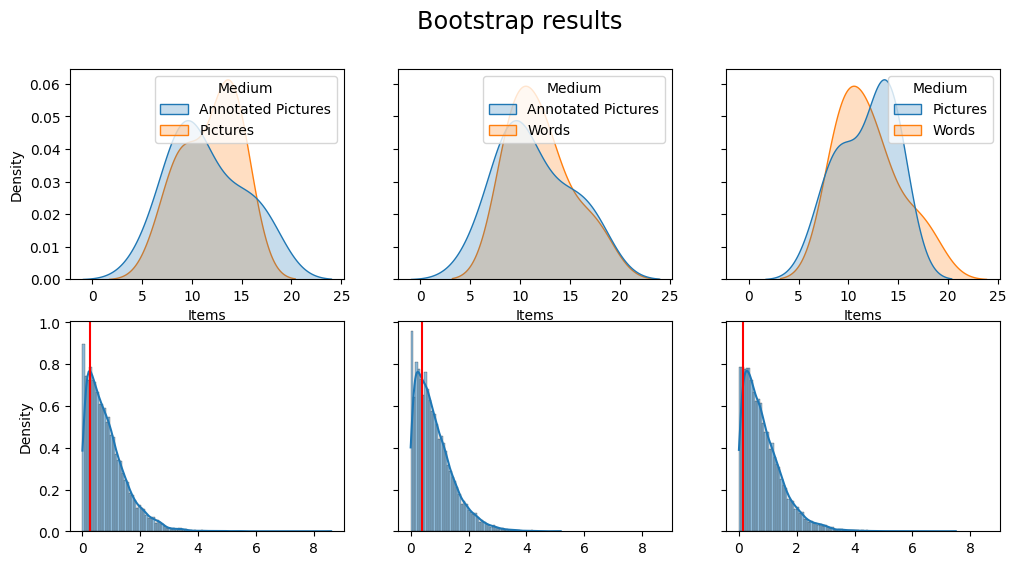

In [83]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), sharey='row', sharex='row')

configs = {'x': "Items", 'hue': "Medium", 'legend': True, 'fill': True}

sns.kdeplot(data=pd.concat([annotated, pictures]), ax=axes[0, 0], **configs)
sns.kdeplot(data=pd.concat([annotated, words]), ax=axes[0, 1], **configs)
sns.kdeplot(data=pd.concat([pictures, words]), ax=axes[0, 2], **configs)

sns.histplot(np.abs(t_boot_ap), kde=True, ax=axes[1, 0], stat='density')
sns.histplot(np.abs(t_boot_aw), kde=True, ax=axes[1, 1], stat='density')
sns.histplot(np.abs(t_boot_pw), kde=True, ax=axes[1, 2], stat='density')

axes[1, 0].axvline(abs(t_c_ap), color='r')
axes[1, 1].axvline(abs(t_c_aw), color='r')
axes[1, 2].axvline(abs(t_c_pw), color='r')

fig.suptitle('Bootstrap results', )

plt.savefig('../figures/Bootstrap_results.png')

# Language level

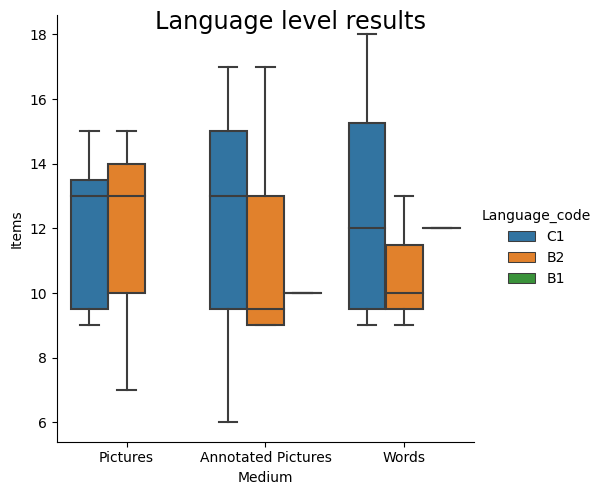

In [94]:
language_results = sns.catplot(data=df, x='Medium', y='Items', hue='Language_code', kind='box')

language_results.fig.suptitle('Language level results')

plt.savefig('../figures/Language_level.png')